### Diabetic Retina Pathology 
##### Imports

In [1]:
!python --version

Python 3.7.10


In [116]:
!pip3 install numpy pandas sklearn tensorflow scikit-image

In [117]:
!pip3 install kaggle opencv-python

## DataSet:

### Kaggle Dataset download:

In [ ]:
# ! kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized

In [9]:
from __future__ import absolute_import, division, print_function
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from glob import glob


In [10]:
import tensorflow as tf
from tensorflow import keras


print("GPU Available: ", tf.config.list_physical_devices('GPU'))


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## GPU Configuration: 
#### If Training on a GPU enabled machine, use the following imports

In [11]:
gpus = tf.config.list_physical_devices('GPU')
tf.debugging.set_log_device_placement(False)

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
#     tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


## Data Set Path Setting: 
### Plase set the following path to be your path to the downloaded kaggle data folder:

In [35]:
YOUR_PATH_TO_DATA_FOLDER = '../'

In [36]:
path = YOUR_PATH_TO_DATA_FOLDER + "resized_train_cropped/"

In [40]:
data = path + "resized_train_cropped/"
print('Input Cropped Image for Model training, total image number - ',len(os.listdir(data)))

Input Cropped Image for Model training, total image number -  35108


## Hyperparameter Configuration: 
#### Be Careful: Too High a Batch Size results in GPU memory issue!

In [178]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils

In [46]:
IMG_SIZE = (512, 512)
BATCH_SIZE = 20
EPOCHS = 200
VALIDATION_STEP_SIZE = 30
STEP_PER_EPOCH = 50 

### Intepretation of the data listed above: 
You are provided with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is the left eye of patient id 1).

A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR



In [51]:
data_frame = pd.read_csv(YOUR_PATH_TO_DATA_FOLDER + "trainLabels_cropped.csv") 

data_frame.head(10)

,Unnamed: 0,Unnamed: 0.1,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1
5,5,5,15_right,2
6,6,6,16_left,4
7,7,7,16_right,4
8,8,8,17_left,0
9,9,9,17_right,1


## Pre-processing and Data Visualization
### Process the image severity level and use one-hot encoding. 

In [52]:
# use pd.concat to join the new columns with your original dataframe
data_frame = pd.concat([data_frame,pd.get_dummies(data_frame['level'], prefix='severity:')],axis=1)

In [56]:
data_frame['path'] = data + data_frame['image']+'.jpeg'

pruned_data = data_frame[['path', 'severity:_0','severity:_1','severity:_2','severity:_3','severity:_4']]

In [57]:
pruned_data.sample(10)

,path,severity:_0,severity:_1,severity:_2,severity:_3,severity:_4
19508,../resized_train_cropped/resized_train_cropped...,0,0,1,0,0
13544,../resized_train_cropped/resized_train_cropped...,1,0,0,0,0
23175,../resized_train_cropped/resized_train_cropped...,0,1,0,0,0
18159,../resized_train_cropped/resized_train_cropped...,0,1,0,0,0
18417,../resized_train_cropped/resized_train_cropped...,1,0,0,0,0
972,../resized_train_cropped/resized_train_cropped...,0,0,1,0,0
14811,../resized_train_cropped/resized_train_cropped...,1,0,0,0,0
10737,../resized_train_cropped/resized_train_cropped...,1,0,0,0,0
24901,../resized_train_cropped/resized_train_cropped...,1,0,0,0,0
21191,../resized_train_cropped/resized_train_cropped...,1,0,0,0,0


## Visualize a random sample from the input: 

In [67]:
np.random.choice(pruned_data['path'])

'../resized_train_cropped/resized_train_cropped/22607_left.jpeg'

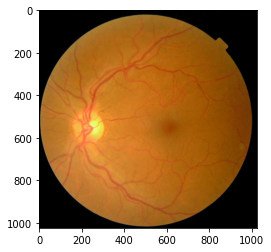

In [68]:
rand_sample_path = np.random.choice(pruned_data['path'])

plt.imshow(plt.imread(rand_sample_path))

## Data Distribution from the input: 
### Specific layout for retinopathy and left/right eyes: 

In [71]:
pruned_data[['severity:_0','severity:_1','severity:_2','severity:_3','severity:_4']].value_counts()

severity:_0  severity:_1  severity:_2  severity:_3  severity:_4
1            0            0            0            0              25802
0            0            1            0            0               5288
             1            0            0            0               2438
             0            0            1            0                872
                                       0            1                708
dtype: int64

array([[<AxesSubplot:title={'center':'severity:_0'}>]], dtype=object)

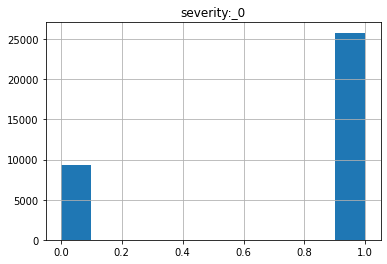

In [73]:
pruned_data[['severity:_0']].hist()

array([[<AxesSubplot:title={'center':'severity:_1'}>]], dtype=object)

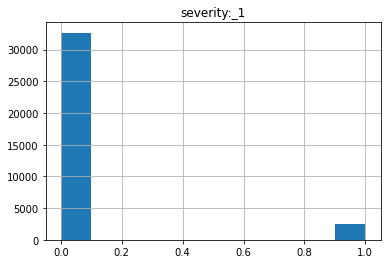

In [74]:
pruned_data[['severity:_1']].hist()

array([[<AxesSubplot:title={'center':'severity:_2'}>]], dtype=object)

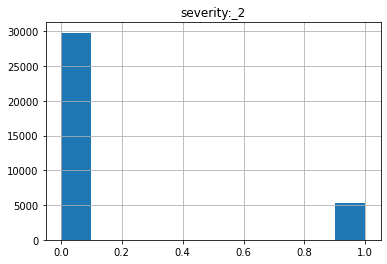

In [75]:
pruned_data[['severity:_2']].hist()


array([[<AxesSubplot:title={'center':'severity:_3'}>]], dtype=object)

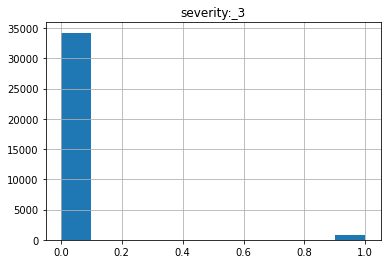

In [76]:
pruned_data[['severity:_3']].hist()

array([[<AxesSubplot:title={'center':'severity:_4'}>]], dtype=object)

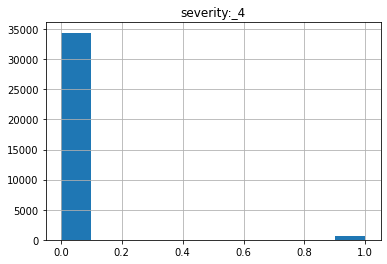

In [77]:
pruned_data[['severity:_4']].hist()

# Test, Validation, Training Data Split: 

In [79]:
train1_ids, valid_ids = train_test_split(pruned_data,test_size = 0.2)
train_and_test = pruned_data[pruned_data.isin(train1_ids)]
train_ids, test_ids = train_test_split(train_and_test,test_size = 0.25)

train_set =train_ids.dropna()
valid_set = valid_ids.dropna()
test_set = test_ids.dropna()

In [83]:
print("Training set image number: ", train_set.shape[0], "\nTesting set image number: ", test_set.shape[0], "\nValidation set image number: ",valid_set.shape[0])


Training set image number:  21056 
Testing set image number:  7030 
Validation set image number:  7022


array([[<AxesSubplot:title={'center':'severity:_0'}>,
        <AxesSubplot:title={'center':'severity:_1'}>],
       [<AxesSubplot:title={'center':'severity:_2'}>,
        <AxesSubplot:title={'center':'severity:_3'}>],
       [<AxesSubplot:title={'center':'severity:_4'}>, <AxesSubplot:>]],
      dtype=object)

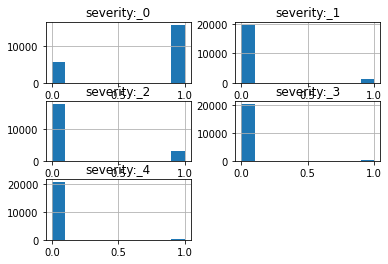

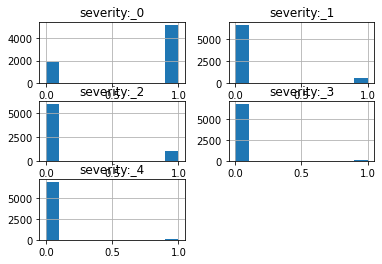

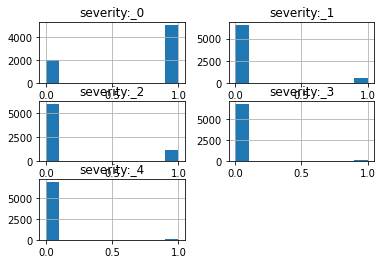

In [92]:
train_set.hist()
valid_set.hist()
test_set.hist()

## Image Data Generation: 

### This function Comes from Brown University CSCI 1430 Project 4, shared repository. 
### By Srinath Sridhar and James Tompkin

In [152]:
import random
from PIL import Image
import skimage
from skimage.transform import resize

In [153]:
"""
Project 4 - CNNs
CS1430 - Computer Vision
Brown University
"""
def calc_mean_and_std(img_directory_list):
        """ Calculate mean and standard deviation of a sample of the
        training dataset for standardization.

        Arguments: none

        Returns: none
        """
        PREPROCESS_SAMPLE_SIZE = 24
        IMG_LENGTH_HEIGHT = 512
         
        # Get list of all images in training directory
        file_list = np.copy(img_directory_list)


        # Shuffle filepaths
        random.shuffle(file_list)

        # Take sample of file paths
        file_list = file_list[:PREPROCESS_SAMPLE_SIZE]

        # Allocate space in memory for images
        data_sample = np.zeros(
            (PREPROCESS_SAMPLE_SIZE,IMG_LENGTH_HEIGHT, IMG_LENGTH_HEIGHT, 3))

        # Import images
        for i, file_path in enumerate(file_list):
            img = Image.open(file_path)
            img = img.resize((IMG_LENGTH_HEIGHT, IMG_LENGTH_HEIGHT))
            img = np.array(img, dtype=np.float32)
#             img /= 255.

            # Grayscale -> RGB
            if len(img.shape) == 2:
                img = np.stack([img, img, img], axis=-1)

            data_sample[i] = img

        # TODO: Calculate the pixel-wise mean and standard deviation
        #       of the images in data_sample and store them in
        #       self.mean and self.std respectively.
        # ==========================================================

        mean = np.mean(data_sample, axis=(0, 1, 2))
        std = np.std(data_sample, axis=(0, 1, 2))

        # ==========================================================

        print("Dataset mean: [{0:.4f}, {1:.4f}, {2:.4f}]".format(
            mean[0], mean[1], mean[2]))

        print("Dataset std: [{0:.4f}, {1:.4f}, {2:.4f}]".format(
            std[0], std[1], std[2]))
        
        return mean, std

In [154]:
train_set_mean, train_set_std = calc_mean_and_std(train_set['path'])

Dataset mean: [100.0720, 70.7503, 52.4094]
Dataset std: [73.8655, 54.9523, 48.1904]


In [155]:
def train_img_preprocess_fn(img):
    img = tf.keras.applications.vgg16.preprocess_input(img)
    for layer in range(img.shape[2]):
            img[:,:,layer] = (img[:,:,layer] - train_set_mean[layer]) / train_set_std[layer]
    return img

## Data Pipeline
### This is our Image Data Generator and data flow pipeline for training data:

In [164]:
def get_processed_data(data_frame):
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                    rotation_range=20,
                    width_shift_range=5,
                    height_shift_range=5,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip = True
    )
    
    data_gen = data_gen.flow_from_dataframe(
        data_frame,
        directory=None,
        x_col="path",
        y_col=['severity:_0','severity:_1','severity:_2','severity:_3','severity:_4'],
        weight_col=None,
        target_size=IMG_SIZE,
        color_mode="rgb",
        classes=None,
        class_mode="raw",
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        save_to_dir=None,
        save_prefix="",
        save_format="png",
        subset=None,
        interpolation="nearest",
        validate_filenames=False,
    )
    
    return data_gen

### No Image preprocessing is done for the validation and testing set.

In [165]:
def get_unprocessed_data(data_frame):
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                    horizontal_flip=True,
                    vertical_flip = True, 
    )
    
    
    data_gen = data_gen.flow_from_dataframe(
        data_frame,
        directory=None,
        x_col="path",
        y_col=['severity:_0','severity:_1','severity:_2','severity:_3','severity:_4'],
        weight_col=None,
        target_size=IMG_SIZE,
        color_mode="rgb",
        classes=None,
        class_mode="raw",
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        save_to_dir=None,
        save_prefix="",
        save_format="png",
        subset=None,
        interpolation="nearest",
        validate_filenames=False,
    )
    
    return data_gen

#### Training Set:

In [166]:
gen_train_set = get_processed_data(train_set)
print(gen_train_set)

Found 21056 non-validated image filenames.


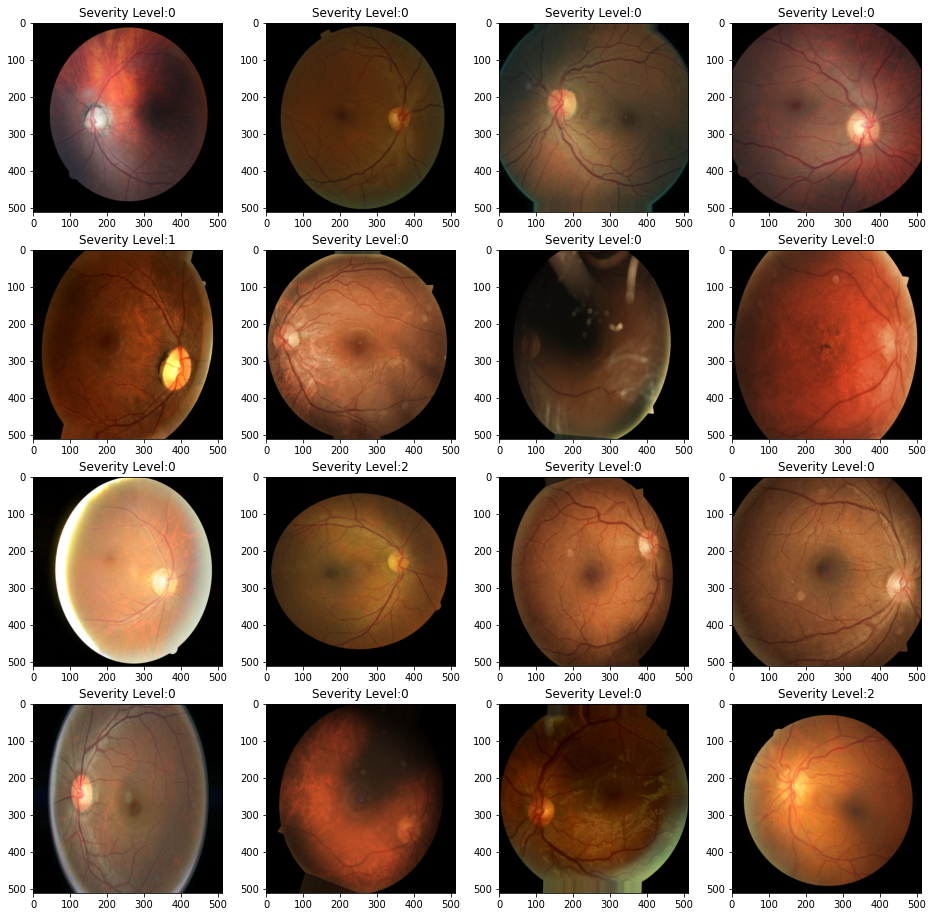

In [172]:
retina_data, retina_sev = next(gen_train_set)
figure, plot_axs = plt.subplots(4, 4, figsize = (16, 16))

for (data, sev, subplt) in zip(retina_data, retina_sev, plot_axs.flatten()):
    clipped = np.clip(data, 0, 255).astype(np.uint8)
    subplt.imshow(clipped)
    subplt.set_title('Severity Level:' + (np.argmax(sev, axis=0).astype('str')))

#### Validation Set:

In [173]:
gen_valid_set = get_unprocessed_data(valid_set)
print(gen_valid_set)

Found 7022 non-validated image filenames.


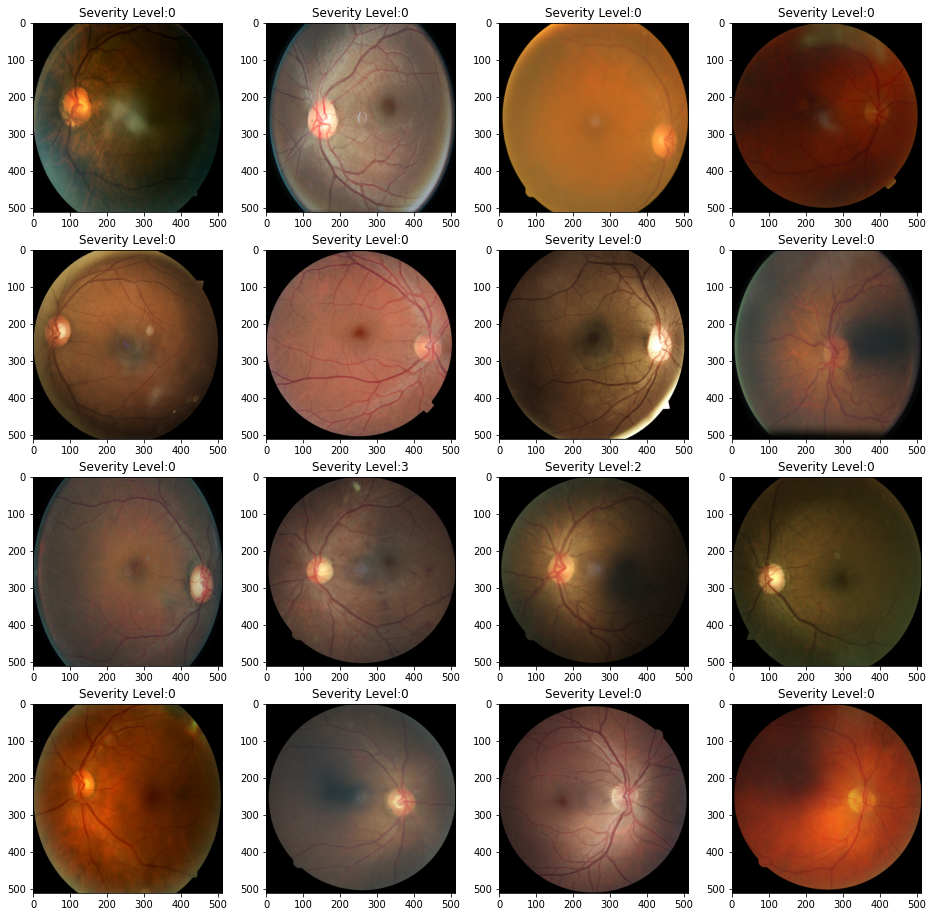

In [175]:
retina_data, retina_sev = next(gen_valid_set)
figure, plot_axs = plt.subplots(4, 4, figsize = (16, 16))

for (data, sev, subplt) in zip(retina_data, retina_sev, plot_axs.flatten()):
    clipped = np.clip(data, 0, 255).astype(np.uint8)
    subplt.imshow(clipped)
    subplt.set_title('Severity Level:' + (np.argmax(sev, axis=0).astype('str')))

#### Test Set:

In [176]:
gen_test_set = get_unprocessed_data(test_set)
print(gen_test_set)

Found 7030 non-validated image filenames.


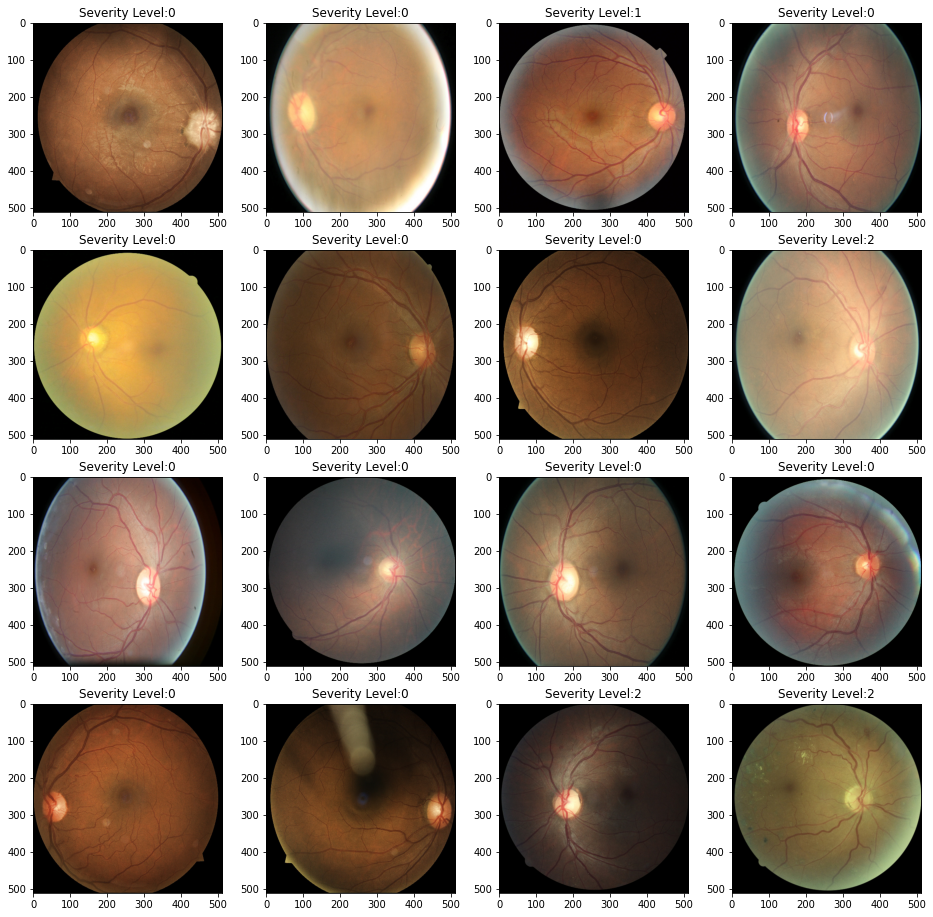

In [177]:
retina_data, retina_sev = next(gen_test_set)
figure, plot_axs = plt.subplots(4, 4, figsize = (16, 16))

for (data, sev, subplt) in zip(retina_data, retina_sev, plot_axs.flatten()):
    clipped = np.clip(data, 0, 255).astype(np.uint8)
    subplt.imshow(clipped)
    subplt.set_title('Severity Level:' + (np.argmax(sev, axis=0).astype('str')))

# Build Model

In [205]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.applications.inception_v3 import InceptionV3 as pretrained_model

In [206]:
def within_accuracy(input_data, input_prediction):
    return top_k_categorical_accuracy(input_data, input_prediction, k=3)

### Getting InceptionV3 for Knowledge Transfer:

In [215]:
input_layer = Input(retina_data.shape[1:])
base_model = pretrained_model(input_shape =  retina_data.shape[1:], include_top = False, weights = 'imagenet')
base_model.trainable = False
base_model.summary()
base_model
after_imagenet = base_model(input_layer)

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 255, 255, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_472 (BatchN (None, 255, 255, 32) 96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 255, 255, 32) 0           batch_normalization_472[0][0]    
_______________________________________________________________________________________

In [222]:
after_imagenet = base_model(input_layer)
batch_normalization_layer = BatchNormalization()(after_imagenet)
out_custom_head = Conv2D(512, 3, 1, padding="same", activation="relu", name="trainable1_head_1")(batch_normalization_layer)
out_custom_head = Conv2D(256, 3, 1, padding="same", activation="relu", name="trainable1_head_2")(out_custom_head)
out_custom_head = Conv2D(128, 3, 1, padding="same", activation="relu", name="trainable1_head_3")(out_custom_head)
                 

In [223]:
out_custom_head = Conv2D(64, 3, 1, padding="same", activation="relu", name="trainable2_head_1")(out_custom_head)
out_custom_head = GlobalAveragePooling2D()(out_custom_head)
out_custom_head=Dense(128,activation='softmax')(out_custom_head)
out_custom_head=Dense(5,activation='softmax')(out_custom_head)

In [224]:
Our_Model = tf.keras.models.Model(inputs = [input_layer], outputs = [out_custom_head])
Our_Model.compile(optimizer = 'adam', 
                     loss = 'categorical_crossentropy',
                     metrics = ['categorical_accuracy', within_accuracy])

Our_Model.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 512, 512, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 14, 14, 2048)      21802784  
_________________________________________________________________
batch_normalization_568 (Bat (None, 14, 14, 2048)      8192      
_________________________________________________________________
trainable1_head_1 (Conv2D)   (None, 14, 14, 512)       9437696   
_________________________________________________________________
trainable1_head_2 (Conv2D)   (None, 14, 14, 256)       1179904   
_________________________________________________________________
trainable1_head_3 (Conv2D)   (None, 14, 14, 128)       295040    
_________________________________________________________________
trainable2_head_1 (Conv2D)   (None, 14, 14, 64)        7379

In [225]:
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,CSVLogger,EarlyStopping,ReduceLROnPlateau 
import sys
import argparse
import re
from datetime import datetime

In [226]:
time_now = datetime.now()
timestamp = time_now.strftime("%m%d%y-%H%M%S")
checkpoint_path = "epoch-{epoch:02d}-val_loss-{val_loss:.2f}_inceptionv3_weights_best.hdf5"
logs_path = "logs" + os.sep + "InceptionV3_model" + os.sep + timestamp + os.sep

In [227]:
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

# Train Model

In [47]:
# !watch -n0.1 nvidia-smi

In [ ]:
model_train = Our_Model.fit(gen_train_set, 
                            steps_per_epoch = STEP_PER_EPOCH,
                            validation_data = gen_valid_set, 
                            validation_steps = VALIDATION_STEP_SIZE,
                            callbacks = [ModelCheckpoint(checkpoint_path, 
                                                         monitor='val_loss', 
                                                         verbose=1,
                                                         save_best_only=True, 
                                                         mode='min', 
                                                         save_weights_only = True,
                                                         save_freq='epoch'), 
                                         EarlyStopping(monitor="val_loss", 
                                          mode="min", 
                                          patience=4), 
                                         CSVLogger('InceptionV3-training.log', 
                                                   separator=",", 
                                                   append=True),
                                         ReduceLROnPlateau(
                                             monitor='val_loss', # monitor	quantity to be monitored.
                                           factor=0.5,         # factor	factor by which the learning rate will be reduced. new_lr = lr * factor.
                                           patience=2, # patience	number of epochs with no improvement after which learning rate will be reduced.
                                           verbose=1, # verbose	int. 0: quiet, 1: update messages.
                                           mode='auto', # mode	one of {'auto', 'min', 'max'}. In 'min' mode, the learning rate will be reduced when the quantity 
                                           min_delta=0.0001, # min_delta	threshold for measuring the new optimum, to only focus on significant changes.
                                           cooldown=3, # cooldown	number of epochs to wait before resuming normal operation after lr has been reduced.
                                           min_lr=0.0001 
                                          )
                            ],
                            epochs = EPOCHS)

Epoch 1/200
 5/50 [==>...........................] - ETA: 1:44 - loss: 1.5707 - categorical_accuracy: 0.4470 - within_accuracy: 0.5210

### Run this if loading from the machine 

In [57]:

Our_Model.load_weights('/home/jupyter/final1430/diabetic_retinopathy/epoch-19-val_loss-0.88_inceptionv3_weights_best.hdf5')


### Run this if it's first time running 

In [56]:
Our_Model.save('inceptionv3_full_model.h5')

## Plot the loss, accuracy and the model: 

In [59]:
Our_Model.history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'within_accuracy', 'val_loss', 'val_categorical_accuracy', 'val_within_accuracy', 'lr'])

# Result Visualization: 

### Calculates the top-k categorical accuracy rate, i.e. success when the target class is within the top-k predictions provided.

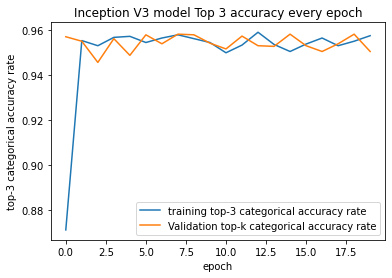

In [63]:
plt.plot(Our_Model.history.history['within_accuracy'])
plt.plot(Our_Model.history.history['val_within_accuracy'])
plt.title('Inception V3 model Top 3 accuracy every epoch')
plt.ylabel('top-3 categorical accuracy rate')
plt.xlabel('epoch')
plt.legend(['training top-3 categorical accuracy rate', 'Validation top-k categorical accuracy rate'], loc='best')
plt.show()

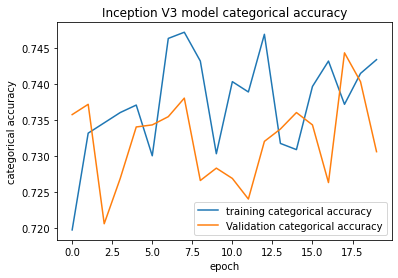

In [64]:
plt.plot(Our_Model.history.history['categorical_accuracy'])
plt.plot(Our_Model.history.history['val_categorical_accuracy'])
plt.title('Inception V3 model categorical accuracy')
plt.ylabel('categorical accuracy')
plt.xlabel('epoch')
plt.legend(['training categorical accuracy', 'Validation categorical accuracy'], loc='best')
plt.show()

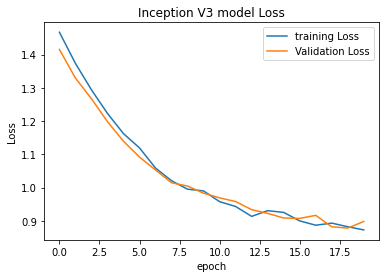

In [65]:
plt.plot(Our_Model.history.history['loss'])
plt.plot(Our_Model.history.history['val_loss'])
plt.title('Inception V3 model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training Loss', 'Validation Loss'], loc='best')
plt.show()